# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

In [2]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

## Models for triloop & tetraloop sequence-specific parameters

(27732, 1399)
CPU times: user 2min 56s, sys: 2min 8s, total: 5min 5s
Wall time: 1min 24s


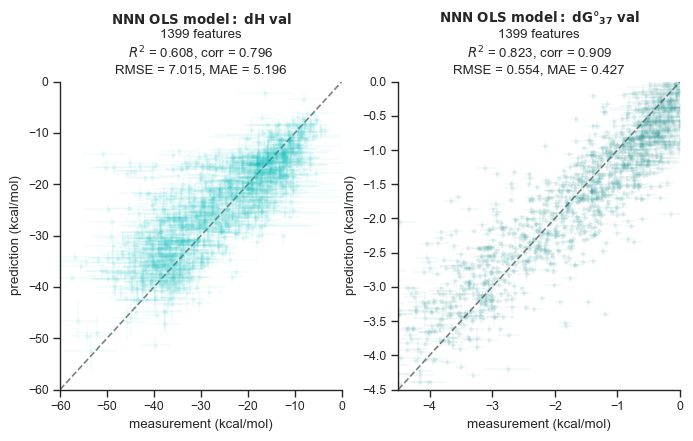

In [105]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True, ignore_base_stack=False)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

### Save parameters to json

In [106]:
param_set_template_file = './models/dna04.json'
out_file = './models/dna-nnn-hairpin.json'
mupack.lr_dict_2_nupack_json(lr_dict, template_file=param_set_template_file, out_file=out_file, 
                             lr_step='hairpin', adjust_triloop_terminal_penalty=True,
                             extract_hairpin_mismatch=True)

### Validation

In [16]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv')
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')

In [107]:
hairpinloop_ind = [x for x in data_split_dict['val_ind'] if (x.startswith('TRI') or x.startswith('TET'))]

In [108]:
%%time
pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn-hairpin.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

CPU times: user 13.8 s, sys: 193 ms, total: 14 s
Wall time: 14 s


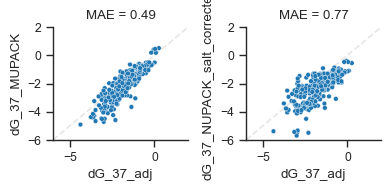

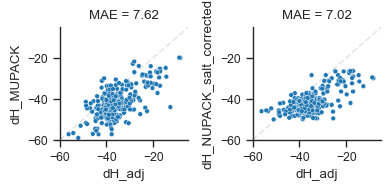

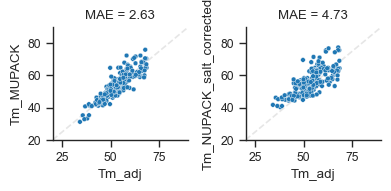

In [109]:
# Compare on array validation data
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-6, 2], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-60, -5], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [20, 90], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_array_val_v1.pdf')

Triloop model works better than the tetraloop model.

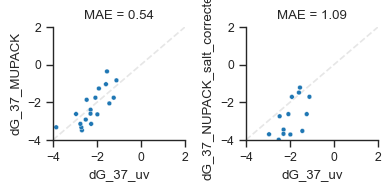

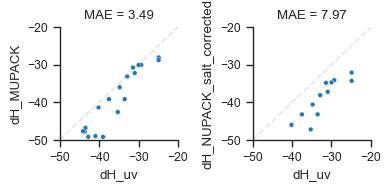

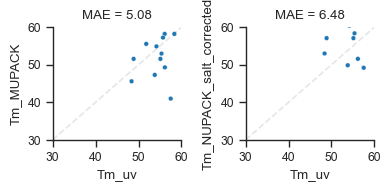

In [122]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = 'WC'
# hairpinloop_ind = [x for x in uv.index if ((x.startswith('TRI') or x.startswith('TET')) and x in arr.index)]
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)) and x in arr.index)]
""" END """

arr[cols] = np.nan
arr.loc[hairpinloop_ind, cols] = uv.loc[hairpinloop_ind, cols]

pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dG_37', [-4, 2], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dH', [-50, -20], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'Tm', [30, 60], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

In [155]:
uv_df = pd.read_csv('./data/models/processed/uv_hairpin_arr_salt_hplc_filtered.csv', index_col=0)
uv_df.TargetStruct = uv_df.TargetStruct.fillna('('*6+'....'+')'*6)

In [160]:
modeling.get_model_prediction(df=uv_df, model='nupack', model_param_file='./models/dna-nnn-full.json', 
                              sodium=0.083, append_df_suffix='_new_NUPACK')

ConversionError: ["could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)", "could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)"]